In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
#from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

In [2]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144788 entries, 0 to 144787
Columns: 139 entries, SellerCode to Payment1st3Months_F
dtypes: float64(36), int64(103)
memory usage: 153.5 MB


In [3]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131877 entries, 0 to 131876
Columns: 143 entries, SellerCode to Payment1st3Months_F
dtypes: float64(36), int64(107)
memory usage: 143.9 MB


In [4]:
medianCityCode = train['citycode'].median(axis=0)
train['citycode'].fillna(medianCityCode, inplace=True)
medianGenderCode = train['GenderCode'].median(axis=0)
train['GenderCode'].fillna(medianGenderCode, inplace=True)
medianCustomerAge = train['CustomerAge'].median(axis=0)
train['CustomerAge'].fillna(medianCustomerAge, inplace=True)

In [5]:
missing_df_train = train.isnull().sum(axis=0).reset_index()
missing_df_train.columns = ['column_name', 'missing_count']
missing_df_train['missing_ratio'] = missing_df_train['missing_count'] / train.shape[0]
missing_df_train.loc[missing_df_train['missing_count']>0]

,column_name,missing_count,missing_ratio


In [6]:
test = test.drop(['Inbound_Count_-12+Month', 'Inbound_Duration_-12+Month',
                  'Inbound_Count_Ever','Inbound_Duration_Ever'], axis=1)

In [7]:
medianCityCode = test['citycode'].median(axis=0)
test['citycode'].fillna(medianCityCode, inplace=True)
medianGenderCode = test['GenderCode'].median(axis=0)
test['GenderCode'].fillna(medianGenderCode, inplace=True)
medianCustomerAge = test['CustomerAge'].median(axis=0)
test['CustomerAge'].fillna(medianCustomerAge, inplace=True)

In [8]:
missing_df_test = test.isnull().sum(axis=0).reset_index()
missing_df_test.columns = ['column_name', 'missing_count']
missing_df_test['missing_ratio'] = missing_df_test['missing_count'] / test.shape[0]
missing_df_test.loc[missing_df_test['missing_count']>0]

,column_name,missing_count,missing_ratio


In [9]:
y_train = train['Payment1st3Months_F']
x_train = train.drop(['Payment1st3Months_F'], axis=1)
y_test = test['Payment1st3Months_F']
x_test = test.drop(['Payment1st3Months_F'], axis=1)

In [10]:
def modelfit(alg, y_train, x_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm
    alg.fit(x_train, y_train)
    #Predict training set
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    #Perform Cross-Validation
    if performCV:
        cv_score = cross_val_score(alg, x_train, y_train, cv=cv_folds, scoring='roc_auc', n_jobs=3)
    #Print Model Report
    print "\nModel Report"
    print "Accuracy: %.4g" %accuracy_score(y_train.values, dtrain_predictions)
    print "AUC Score (Train): %f" %roc_auc_score(y_train, dtrain_predprob)
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" \
        % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, x_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy: 0.953
AUC Score (Train): 0.786724
CV Score : Mean - 0.7734883 | Std - 0.00637333 | Min - 0.7611709 | Max - 0.7792606


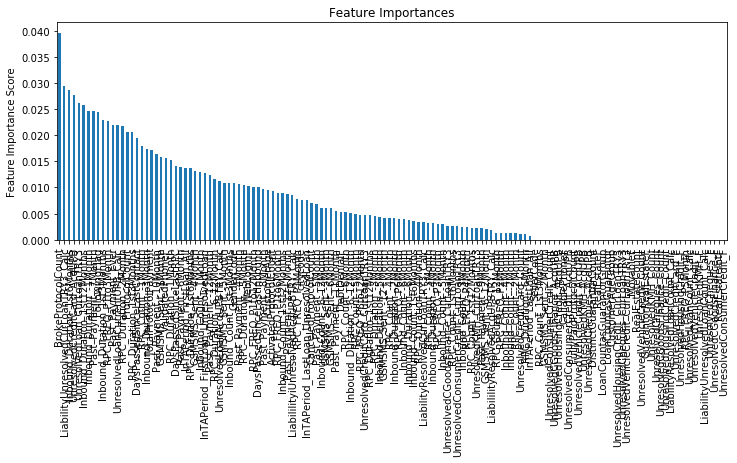

In [11]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier()
modelfit(gbm0, y_train, x_train)


Model Report
Accuracy: 0.953
AUC Score (Train): 0.786724
CV Score : Mean - 0.7735236 | Std - 0.006357803 | Min - 0.761222 | Max - 0.7792458


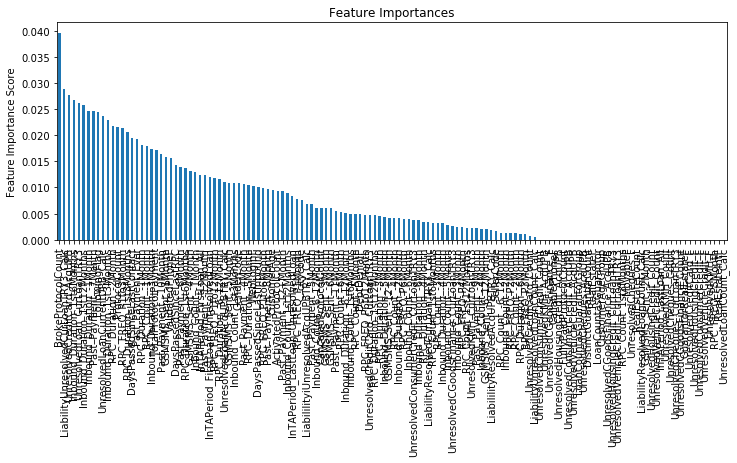

In [12]:
#Choose all predictors except target & IDcols
gbm1 = GradientBoostingClassifier(random_state=10)
modelfit(gbm1, y_train, x_train)

In [13]:
#Choose all predictors except target & IDcols
start = time.time()
param_test1 = {'n_estimators':range(20,201,20)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=6,iid=False, cv=5)
gsearch1.fit(x_train, y_train)
end = time.time()
print(end - start)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

1590.89899993


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76316, std: 0.00716, params: {'n_estimators': 20},
  mean: 0.77039, std: 0.00658, params: {'n_estimators': 40},
  mean: 0.77251, std: 0.00635, params: {'n_estimators': 60},
  mean: 0.77322, std: 0.00630, params: {'n_estimators': 80},
  mean: 0.77352, std: 0.00636, params: {'n_estimators': 100},
  mean: 0.77373, std: 0.00637, params: {'n_estimators': 120},
  mean: 0.77399, std: 0.00643, params: {'n_estimators': 140},
  mean: 0.77409, std: 0.00643, params: {'n_estimators': 160},
  mean: 0.77427, std: 0.00652, params: {'n_estimators': 180},
  mean: 0.77429, std: 0.00654, params: {'n_estimators': 200}],
 {'n_estimators': 200},
 0.77429416009681284)

In [16]:
start = time.time()
param_test2 = {'max_depth':range(2,10,1)}
gsearch2 = GridSearchCV(estimator \
                        = GradientBoostingClassifier(random_state=10,
                                                    n_estimators=200), 
param_grid = param_test2, scoring='roc_auc',n_jobs=6,iid=False, cv=5)
gsearch2.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

6184.91199994


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77368, std: 0.00669, params: {'max_depth': 2},
  mean: 0.77429, std: 0.00654, params: {'max_depth': 3},
  mean: 0.77384, std: 0.00649, params: {'max_depth': 4},
  mean: 0.77265, std: 0.00715, params: {'max_depth': 5},
  mean: 0.77029, std: 0.00705, params: {'max_depth': 6},
  mean: 0.76573, std: 0.00731, params: {'max_depth': 7},
  mean: 0.76029, std: 0.00655, params: {'max_depth': 8},
  mean: 0.75531, std: 0.00434, params: {'max_depth': 9}],
 {'max_depth': 3},
 0.77429416009681284)

In [18]:
start = time.time()
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=200,
                                                               max_depth = 3), 
param_grid = param_test3, scoring='roc_auc',n_jobs=6,iid=False, cv=5)
gsearch3.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

7977.602


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77463, std: 0.00655, params: {'min_samples_split': 1000, 'min_samples_leaf': 30},
  mean: 0.77483, std: 0.00664, params: {'min_samples_split': 1200, 'min_samples_leaf': 30},
  mean: 0.77483, std: 0.00665, params: {'min_samples_split': 1400, 'min_samples_leaf': 30},
  mean: 0.77490, std: 0.00644, params: {'min_samples_split': 1600, 'min_samples_leaf': 30},
  mean: 0.77448, std: 0.00653, params: {'min_samples_split': 1800, 'min_samples_leaf': 30},
  mean: 0.77500, std: 0.00661, params: {'min_samples_split': 2000, 'min_samples_leaf': 30},
  mean: 0.77455, std: 0.00672, params: {'min_samples_split': 1000, 'min_samples_leaf': 40},
  mean: 0.77474, std: 0.00665, params: {'min_samples_split': 1200, 'min_samples_leaf': 40},
  mean: 0.77481, std: 0.00646, params: {'min_samples_split': 1400, 'min_samples_leaf': 40},
  mean: 0.77434, std: 0.00653, params: {'min_samples_split': 1600, 'min_samples_leaf': 40},
  mean: 0.77450, std: 0.00663, params: {'min_samples_split': 1800, 'min_samples_

In [19]:
start = time.time()
param_test4 = {'max_features':range(10,40,5)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                     n_estimators=200,
                                                     max_depth = 3,
                                                     min_samples_split = 2000,
                                                     min_samples_leaf = 30),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

365.30700016


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77347, std: 0.00606, params: {'max_features': 10},
  mean: 0.77469, std: 0.00590, params: {'max_features': 15},
  mean: 0.77444, std: 0.00660, params: {'max_features': 20},
  mean: 0.77451, std: 0.00652, params: {'max_features': 25},
  mean: 0.77510, std: 0.00605, params: {'max_features': 30},
  mean: 0.77456, std: 0.00638, params: {'max_features': 35}],
 {'max_features': 30},
 0.77509934755301457)

In [20]:
start = time.time()
param_test5 = {'subsample':[0.6,0.7,0.8,0.9,1]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=200,
                                                               max_depth = 3,
                                                               min_samples_split = 2000,
                                                               min_samples_leaf = 30,
                                                               max_features = 30),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

358.002000093


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77331, std: 0.00625, params: {'subsample': 0.6},
  mean: 0.77390, std: 0.00671, params: {'subsample': 0.7},
  mean: 0.77429, std: 0.00636, params: {'subsample': 0.8},
  mean: 0.77400, std: 0.00643, params: {'subsample': 0.9},
  mean: 0.77510, std: 0.00605, params: {'subsample': 1}],
 {'subsample': 1},
 0.77509934755301457)

In [21]:
start = time.time()
param_test6 = {'learning_rate':[0.03,0.05,0.08,0.1,0.12,0.15]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=200,
                                                               max_depth = 3,
                                                               min_samples_split = 2000,
                                                               min_samples_leaf = 30,
                                                               max_features = 30,
                                                               subsample=1),
param_grid = param_test6, scoring='roc_auc',n_jobs=6,iid=False, cv=5)
gsearch6.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

464.802999973


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77281, std: 0.00679, params: {'learning_rate': 0.03},
  mean: 0.77425, std: 0.00618, params: {'learning_rate': 0.05},
  mean: 0.77507, std: 0.00557, params: {'learning_rate': 0.08},
  mean: 0.77510, std: 0.00605, params: {'learning_rate': 0.1},
  mean: 0.77477, std: 0.00628, params: {'learning_rate': 0.12},
  mean: 0.77499, std: 0.00599, params: {'learning_rate': 0.15}],
 {'learning_rate': 0.1},
 0.77509934755301457)

In [24]:
start = time.time()
param_test7 = {'learning_rate':[0.03,0.05,0.08,0.1,0.12,0.15]}
gsearch7 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=200,
                                                               max_depth = 3,
                                                               min_samples_split = 2000,
                                                               min_samples_leaf = 30,
                                                               subsample=1),
param_grid = param_test7, scoring='roc_auc',n_jobs=6,iid=False, cv=5)
gsearch7.fit(x_train,y_train)
end = time.time()
print(end - start)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

1755.46600008


C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77295, std: 0.00666, params: {'learning_rate': 0.03},
  mean: 0.77405, std: 0.00664, params: {'learning_rate': 0.05},
  mean: 0.77433, std: 0.00685, params: {'learning_rate': 0.08},
  mean: 0.77500, std: 0.00661, params: {'learning_rate': 0.1},
  mean: 0.77478, std: 0.00610, params: {'learning_rate': 0.12},
  mean: 0.77453, std: 0.00659, params: {'learning_rate': 0.15}],
 {'learning_rate': 0.1},
 0.77500380714181449)


Model Report
Accuracy: 0.9531
AUC Score (Train): 0.790745
CV Score : Mean - 0.7750038 | Std - 0.006614637 | Min - 0.7622039 | Max - 0.7803478
Accuracy for Gradient Boosting:
0.977160535954
Confusion Matrix for Gradient Boosting
[[128815    150]
 [  2862     50]]
F1 Score for Gradient Boosting
0.0321336760925
AUC Score for Gradient Boosting
0.783771442908


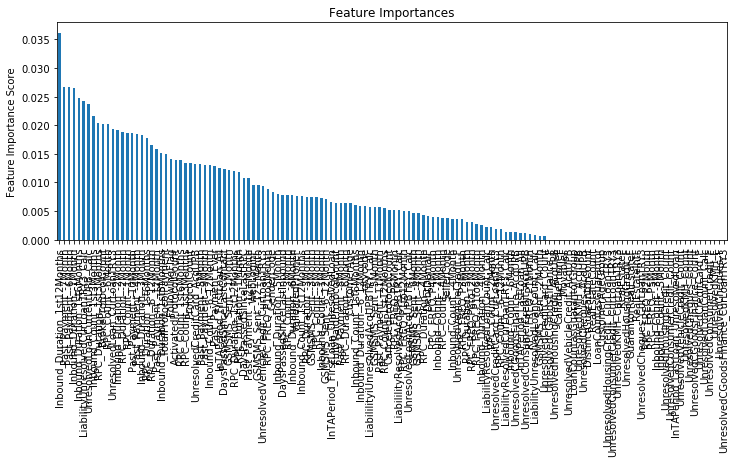

In [25]:
gbm6 = GradientBoostingClassifier(random_state=10,
                                  n_estimators=200,
                                  max_depth = 3,
                                  min_samples_split = 2000,
                                  min_samples_leaf = 30,
                                  subsample=1,
                                  learning_rate=0.1)
modelfit(gbm6, y_train, x_train)
y_pred_gbm = gbm6.predict(x_test)
y_pred_proba_gbm = gbm6.predict_proba(x_test)[:,1]
print('Accuracy for Gradient Boosting:')
print(accuracy_score(y_test, y_pred_gbm))
print('Confusion Matrix for Gradient Boosting')
print(confusion_matrix(y_test, y_pred_gbm))
print('F1 Score for Gradient Boosting')
print(f1_score(y_test, y_pred_gbm))
print('AUC Score for Gradient Boosting')
print(roc_auc_score(y_test, y_pred_proba_gbm))

In [14]:
gbm1 = GradientBoostingClassifier(n_estimators=200,random_state=10)
gbm1.fit(x_test, y_test)
y_pred_gbm = gbm1.predict(x_test)
y_pred_proba_gbm = gbm1.predict_proba(x_test)[:,1]
print('Accuracy for Gradient Boosting:')
print(accuracy_score(y_test, y_pred_gbm))
print('Confusion Matrix for Gradient Boosting')
print(confusion_matrix(y_test, y_pred_gbm))
print('F1 Score for Gradient Boosting')
print(f1_score(y_test, y_pred_gbm))
print('AUC Score for Gradient Boosting')
print(roc_auc_score(y_test, y_pred_proba_gbm))

Accuracy for Gradient Boosting:
0.978843922746
Confusion Matrix for Gradient Boosting
[[128961      4]
 [  2786    126]]
F1 Score for Gradient Boosting
0.0828402366864
AUC Score for Gradient Boosting
0.814606364684


In [15]:
gbm0 = GradientBoostingClassifier(n_estimators=100,random_state=10)
gbm0.fit(x_test, y_test)
y_pred_gbm = gbm0.predict(x_test)
y_pred_proba_gbm = gbm0.predict_proba(x_test)[:,1]
print('Accuracy for Gradient Boosting:')
print(accuracy_score(y_test, y_pred_gbm))
print('Confusion Matrix for Gradient Boosting')
print(confusion_matrix(y_test, y_pred_gbm))
print('F1 Score for Gradient Boosting')
print(f1_score(y_test, y_pred_gbm))
print('AUC Score for Gradient Boosting')
print(roc_auc_score(y_test, y_pred_proba_gbm))

Accuracy for Gradient Boosting:
0.97844961593
Confusion Matrix for Gradient Boosting
[[128962      3]
 [  2839     73]]
F1 Score for Gradient Boosting
0.0488621151272
AUC Score for Gradient Boosting
0.804918837124


In [22]:
gbm6 = GradientBoostingClassifier(random_state=10,
                                  n_estimators=200,
                                  max_depth = 3,
                                  min_samples_split = 2000,
                                  min_samples_leaf = 30,
                                  max_features = 30,
                                  subsample=1,
                                  learning_rate=0.1)
gbm6.fit(x_test, y_test)
y_pred_gbm = gbm6.predict(x_test)
y_pred_proba_gbm = gbm6.predict_proba(x_test)[:,1]
print('Accuracy for Gradient Boosting:')
print(accuracy_score(y_test, y_pred_gbm))
print('Confusion Matrix for Gradient Boosting')
print(confusion_matrix(y_test, y_pred_gbm))
print('F1 Score for Gradient Boosting')
print(f1_score(y_test, y_pred_gbm))
print('AUC Score for Gradient Boosting')
print(roc_auc_score(y_test, y_pred_proba_gbm))

Accuracy for Gradient Boosting:
0.978108388878
Confusion Matrix for Gradient Boosting
[[128958      7]
 [  2880     32]]
F1 Score for Gradient Boosting
0.0216875635378
AUC Score for Gradient Boosting
0.806984125623



Model Report
Accuracy: 0.9529
AUC Score (Train): 0.789168
CV Score : Mean - 0.7750993 | Std - 0.006045921 | Min - 0.7634371 | Max - 0.7800752
Accuracy for Gradient Boosting:
0.977357689362
Confusion Matrix for Gradient Boosting
[[128848    117]
 [  2869     43]]
F1 Score for Gradient Boosting
0.0279947916667
AUC Score for Gradient Boosting
0.783301575136


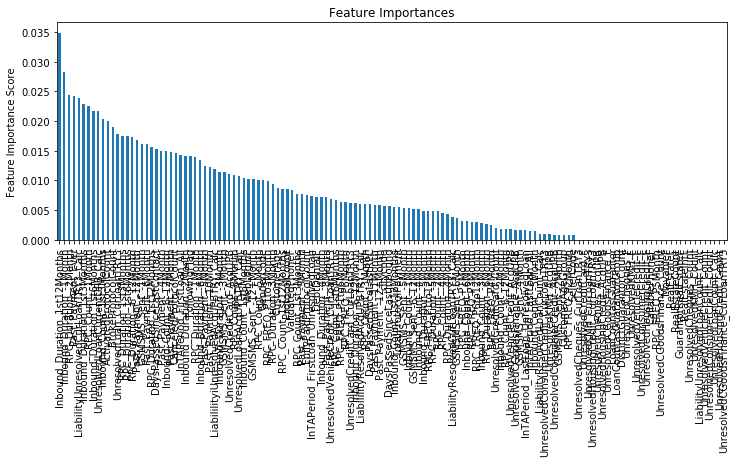

In [23]:
gbm6 = GradientBoostingClassifier(random_state=10,
                                  n_estimators=200,
                                  max_depth = 3,
                                  min_samples_split = 2000,
                                  min_samples_leaf = 30,
                                  max_features = 30,
                                  subsample=1,
                                  learning_rate=0.1)
modelfit(gbm6, y_train, x_train)
y_pred_gbm = gbm6.predict(x_test)
y_pred_proba_gbm = gbm6.predict_proba(x_test)[:,1]
print('Accuracy for Gradient Boosting:')
print(accuracy_score(y_test, y_pred_gbm))
print('Confusion Matrix for Gradient Boosting')
print(confusion_matrix(y_test, y_pred_gbm))
print('F1 Score for Gradient Boosting')
print(f1_score(y_test, y_pred_gbm))
print('AUC Score for Gradient Boosting')
print(roc_auc_score(y_test, y_pred_proba_gbm))